### Reference
* [dowhy_estimation_methods.ipynb](https://github.com/py-why/dowhy/blob/main/docs/source/example_notebooks/dowhy_estimation_methods.ipynb)
* [Methods for inferring Causality](https://towardsdatascience.com/methods-for-inferring-causality-52e4144f6865)
* [do_sampler_demo.ipynb](https://github.com/py-why/dowhy/blob/main/docs/source/example_notebooks/do_sampler_demo.ipynb)

In [1]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Config dict to set the logging level
import logging
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
logging.info("Getting started with DoWhy. Running notebook...")

from IPython.display import Image, display

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
C = 10 * np.random.random(size=20000)
T = np.array([1 if i + np.random.normal(0, 2) > 5 else 0 for i in C])
Y = np.array([1.2 * C[ix] + np.random.normal(0, 1) if i == 0 else 2 * C[ix] - 2 + np.random.normal(0, 1) for ix, i in enumerate(T)])

In [4]:
df = pd.DataFrame({
    'T': T, 'C': C, 'Y': Y
})
df

,T,C,Y
0,0,0.996509,0.868708
1,0,0.018023,-3.127808
2,0,5.483702,5.774961
3,0,4.685957,6.516309
4,0,7.462324,8.109935
...,...,...,...
19995,0,0.882085,1.552270
19996,0,4.427622,3.336179
19997,1,5.855486,10.884944
19998,0,0.453890,0.752502


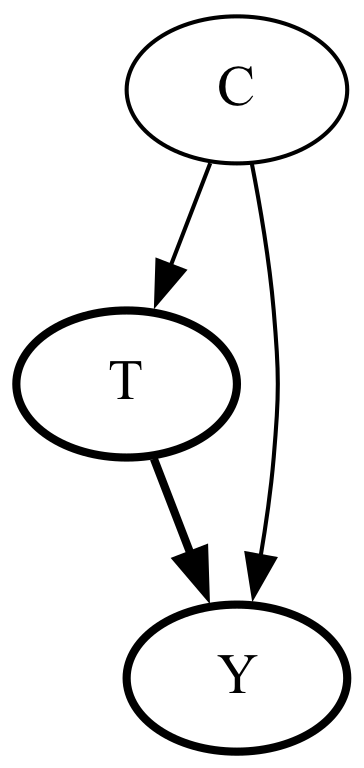

In [5]:
model = CausalModel(
    data=df,
    treatment='T',
    outcome='Y',
    common_causes='C',
)

model.view_model()
display(Image(filename="causal_model.png"))

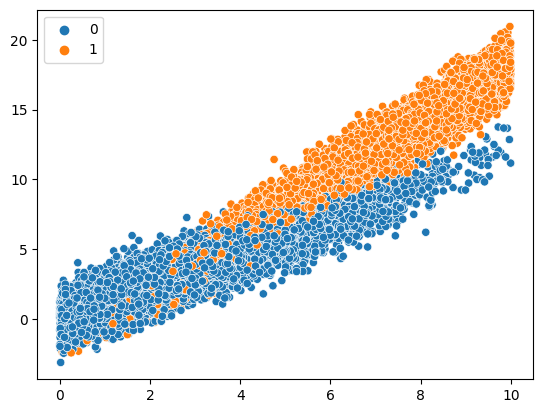

In [6]:
sns.scatterplot(x=C, y=Y, hue=T)
plt.show()

In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|C])
d[T]        
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,C,U) = P(Y|T,C)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
from dowhy.do_samplers.weighting_sampler import WeightingSampler
from dowhy.do_samplers.multivariate_weighting_sampler import MultivariateWeightingSampler

In [10]:
sampler = WeightingSampler(
    df, 
    causal_model=model,
    keep_original_treatment=True,
    variable_types={
        "T": 'b', # binary
        "C": 'c', # continuous
        "Y": 'c', # continuous
    }
)

interventional_df = sampler.do_sample(None)
interventional_df

,T,C,Y,propensity_score,weight
0,1,3.985905,5.852010,0.297455,3.361856
1,0,1.810763,1.536604,0.938360,1.065689
2,1,5.386176,9.330055,0.584220,1.711685
3,0,9.293241,11.895868,0.024431,40.932055
4,1,5.122737,8.077934,0.528579,1.891865
...,...,...,...,...,...
19995,1,4.772604,7.677290,0.453756,2.203829
19996,1,8.864887,13.999429,0.965116,1.036145
19997,0,7.742967,8.742491,0.086344,11.581514
19998,0,7.291698,7.147936,0.122118,8.188775
